<a href="https://colab.research.google.com/github/schreinersoft/big5-ki-personality/blob/main/Universal_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine-Tuning ausgehend von pretrained model

##Setup

In [ ]:
modelckpt = "distilbert-base-uncased"
modelckpt = "distilbert-base-cased"
model_name = f"{modelckpt}-test-finetuned-sms-spam"
dataset_name = "emotion"
dataset_name = "ucirvine/sms_spam"
num_labels = 6
num_labels = 2

In [ ]:
!pip install datasets
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(modelckpt)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset
dataset = load_dataset(dataset_name)


In [ ]:
def tokenize(batch):
  return tokenizer(batch["sms"], padding=True, truncation=True)
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [ ]:
# Check if the dataset only has a 'train' split
if "train" in dataset_encoded and len(dataset_encoded) == 1:
    dataset_encoded = dataset_encoded["train"].train_test_split(test_size=0.2, seed=42)
    dataset_encoded["validation"] = dataset_encoded.pop("test")
    print("Dataset split into train, validation")
elif "train" in dataset_encoded and "test" in dataset_encoded:
  dataset_encoded["validation"] = dataset_encoded["test"]
  print("Dataset already has train and test, renamed test to validation")
else:
  print("Dataset already has train, validation and test splits")
dataset_encoded

Dataset split into train, validation


DatasetDict({
    train: Dataset({
        features: ['sms', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4459
    })
    validation: Dataset({
        features: ['sms', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1115
    })
})

In [ ]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['sms', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4459
    })
    validation: Dataset({
        features: ['sms', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1115
    })
})

#Training

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Add num_labels to match the number of emotion labels
model = AutoModelForSequenceClassification.from_pretrained(modelckpt, num_labels=num_labels).to(device)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###Metriken hinzufügen

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def computemetrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}


###Huggingface einloggen

In [ ]:
from huggingface_hub import notebook_login
import os
notebook_login()


In [ ]:
from transformers import Trainer, TrainingArguments
batchsize = 64
loggingsteps = len(dataset_encoded["train"]) // batchsize
trainingargs = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batchsize,
    per_device_eval_batch_size=batchsize,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    logging_steps=loggingsteps,
    push_to_hub=True,
    log_level="error"
    )
wandb_token="fa13d32d1d1b21d514ddc7a16dd7b8729598b090"

In [ ]:
from transformers import Trainer
trainer = Trainer(model=model, args=trainingargs, compute_metrics=computemetrics, train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["validation"], tokenizer=tokenizer)
trainer.train();


<ipython-input-42-845aa533bf99>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=trainingargs, compute_metrics=computemetrics, train_dataset=dataset_encoded["train"],
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 54


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 54


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.173600,0.048246,0.987444,0.987258
2,0.035700,0.037241,0.989238,0.989144
3,0.016700,0.038662,0.990135,0.990063


In [ ]:
predsoutput = trainer.predict(dataset_encoded["validation"])


In [ ]:
predsoutput.metrics

{'test_loss': 0.03866191208362579,
 'test_accuracy': 0.9901345291479821,
 'test_f1': 0.99006308570125,
 'test_runtime': 10.2379,
 'test_samples_per_second': 108.909,
 'test_steps_per_second': 1.758}

In [ ]:
import numpy as np
y_preds = np.argmax(predsoutput.predictions, axis=1)


###Confusion Matrix zur Visualisierung

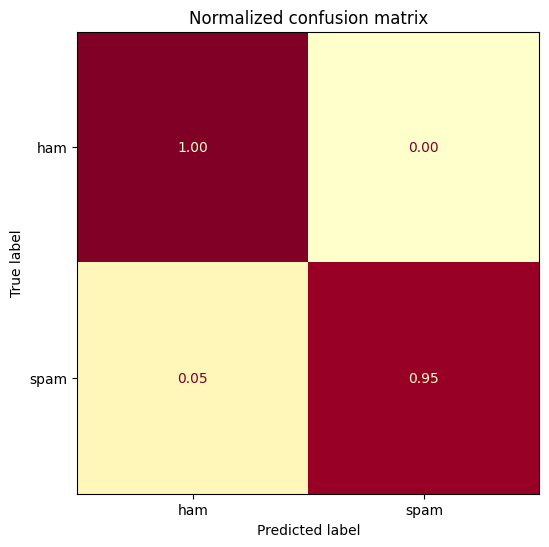

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(ypreds, ytrue, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="YlOrRd", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()
y_valid = dataset_encoded["validation"]["label"]
labels = dataset_encoded["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)


##Error analysis: loss je kategorie ermitteln

In [ ]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(), "predictedlabel": pred_label.cpu().numpy()}



In [ ]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
dataset_encoded["validation"] = dataset_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)


Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

In [ ]:
def label_int2str(row):
  return dataset_encoded["train"].features["label"].int2str(row)


In [ ]:
dataset_encoded.set_format("pandas")
cols = ["sms", "label", "predictedlabel", "loss"]
dftest = dataset_encoded["validation"][:][cols]
dftest["label"] = dftest["label"].apply(label_int2str)
dftest["predictedlabel"] = (dftest["predictedlabel"] .apply(label_int2str))


In [ ]:
dftest[dftest["predictedlabel"]!=dftest["label"]].sort_values("loss", ascending=True)

,sms,label,predictedlabel,loss
43,Are you unique enough? Find out from 30th Augu...,spam,ham,0.869246
389,"Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry ...",spam,ham,1.146422
1092,"Don't Think About ""What u Have Got"" Think Abou...",ham,spam,1.888358
192,Open rebtel with firefox. When it loads just p...,ham,spam,2.408180
447,This message is brought to you by GMW Ltd. and...,spam,ham,2.469252
1095,My tuition is at 330. Hm we go for the 1120 to...,ham,spam,3.576995
811,ROMCAPspam Everyone around should be respondin...,spam,ham,3.616505
365,For sale - arsenal dartboard. Good condition b...,spam,ham,4.879792
1052,"Do you realize that in about 40 years, we'll h...",spam,ham,5.253751
347,Money i have won wining number 946 wot do i do...,spam,ham,5.845730


###schlechteste Vorhersagen suchen und auf eventuelle Fehler im Datensatz prüfen

In [ ]:
dftest.sort_values("loss", ascending=False).head(10)

,sms,label,predictedlabel,loss
458,Hello darling how are you today? I would love ...,spam,ham,6.148355
347,Money i have won wining number 946 wot do i do...,spam,ham,5.845730
1052,"Do you realize that in about 40 years, we'll h...",spam,ham,5.253751
365,For sale - arsenal dartboard. Good condition b...,spam,ham,4.879792
811,ROMCAPspam Everyone around should be respondin...,spam,ham,3.616505
1095,My tuition is at 330. Hm we go for the 1120 to...,ham,spam,3.576995
447,This message is brought to you by GMW Ltd. and...,spam,ham,2.469252
192,Open rebtel with firefox. When it loads just p...,ham,spam,2.408180
1092,"Don't Think About ""What u Have Got"" Think Abou...",ham,spam,1.888358
389,"Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry ...",spam,ham,1.146422


###Beste Vorhersagen prüfen, z.B. auf Shortcuts (zu einfache Signale im Text)

In [ ]:
dftest.sort_values("loss", ascending=True).head(10)


,sms,label,predictedlabel,loss
871,No need lar i go engin? Cos my sis at arts tod...,ham,ham,0.001301
1030,Pls call me da. What happen.\n,ham,ham,0.001305
30,In meeting da. I will call you\n,ham,ham,0.001307
244,Or i go home first lar ü wait 4 me lor.. I put...,ham,ham,0.001308
861,I had askd u a question some hours before. Its...,ham,ham,0.001321
312,He also knows about lunch menu only da. . I kn...,ham,ham,0.001326
134,Yup but it's not giving me problems now so may...,ham,ham,0.001339
416,Cuz ibored. And don wanna study\n,ham,ham,0.001343
1043,Hey check it da. I have listed da.\n,ham,ham,0.001344
855,Aiyah then i wait lor. Then u entertain me. He...,ham,ham,0.001347


In [ ]:
dftest[dftest["predictedlabel"]!=dftest["label"]].sort_values("loss", ascending=True).head(10)

,sms,label,predictedlabel,loss
43,Are you unique enough? Find out from 30th Augu...,spam,ham,0.869246
389,"Goal! Arsenal 4 (Henry, 7 v Liverpool 2 Henry ...",spam,ham,1.146422
1092,"Don't Think About ""What u Have Got"" Think Abou...",ham,spam,1.888358
192,Open rebtel with firefox. When it loads just p...,ham,spam,2.408180
447,This message is brought to you by GMW Ltd. and...,spam,ham,2.469252
1095,My tuition is at 330. Hm we go for the 1120 to...,ham,spam,3.576995
811,ROMCAPspam Everyone around should be respondin...,spam,ham,3.616505
365,For sale - arsenal dartboard. Good condition b...,spam,ham,4.879792
1052,"Do you realize that in about 40 years, we'll h...",spam,ham,5.253751
347,Money i have won wining number 946 wot do i do...,spam,ham,5.845730


##Auf Huggingface publizieren

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")


events.out.tfevents.1735983979.da9e0f0c2932.1026.0:   0%|          | 0.00/7.12k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/joiner75/distilbert-base-cased-test-finetuned-sms-spam/commit/8084ad29cc5a82630cc166544dc9fd36d1c92970', commit_message='Training completed!', commit_description='', oid='8084ad29cc5a82630cc166544dc9fd36d1c92970', pr_url=None, repo_url=RepoUrl('https://huggingface.co/joiner75/distilbert-base-cased-test-finetuned-sms-spam', endpoint='https://huggingface.co', repo_type='model', repo_id='joiner75/distilbert-base-cased-test-finetuned-sms-spam'), pr_revision=None, pr_num=None)

##Pipeline mit dem eigenen Modell einrichten

In [ ]:
from transformers import pipeline
modelid = f"joiner75/{model_name}"
classifier = pipeline("text-classification", model=modelid)


config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
text = "Hello Bernd, would you like to meet next sunday?"
text = "Find all that you need at https://www.goods.com. good prices, big wins"

preds = classifier(text, return_all_scores=True)


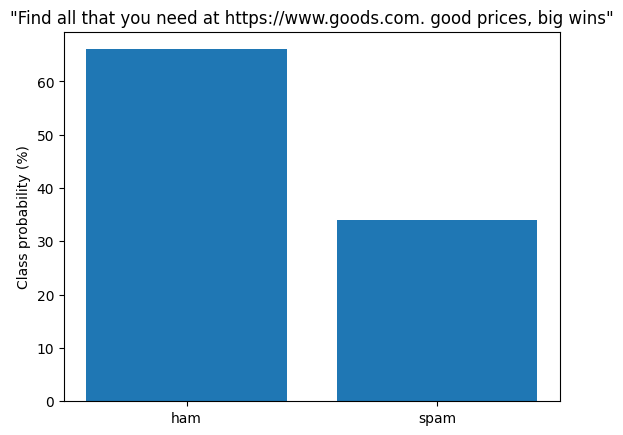

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
predsdf = pd.DataFrame(preds[0])
plt.bar(labels, 100 * predsdf["score"], color='C0')
plt.title(f'"{text}"')
plt.ylabel("Class probability (%)")
plt.show()


In [ ]:
predsdf

,label,score
0,LABEL_0,0.660208
1,LABEL_1,0.339792
